In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Define categories and their respective sounds
CATEGORIES = {
    'Animal': ['dog', 'cat', 'cow', 'tiger', 'lion'],
    'Vehicle': ['car horn', 'engine sound', 'siren'],
    'Nature': ['rain', 'thunder', 'wind'],
    'Music': ['piano', 'guitar', 'drum'],
    'Industrial': ['drilling']
}

In [6]:
# Load dataset and extract features
def extract_features(file_path, n_mfcc=40):
    try:
        if not os.path.isfile(file_path):
            print(f'File not found: {file_path}')
            return None
        audio, sample_rate = librosa.load(file_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, n_fft=1024, hop_length=512)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f'Error encountered while parsing file: {file_path}', e)
        return None
    return mfccs_scaled

In [7]:
# Load data
audio_dataset_path = 'sound_datasets/audio'
metadata = pd.read_csv('sound_datasets/metadata/Sound.csv')
metadata.columns = metadata.columns.str.strip()  # Fix column names

In [8]:
# Extract features and prepare dataset
features = []
for _, row in metadata.iterrows():
    file_path = os.path.join(audio_dataset_path, f'fold{row["fold"]}/{row["slice_file_name"]}')
    class_label = row['class']
    data = extract_features(file_path)
    if data is not None:
        features.append([data, class_label])

In [9]:
# Convert features to DataFrame
features_df = pd.DataFrame(features, columns=['feature', 'class'])
X = np.array(features_df['feature'].tolist())
y = np.array(features_df['class'].tolist())

In [10]:
# Encode labels and split data
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Model architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(40,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\ASHUTOSH PATIL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [13]:
# Model training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3258 - loss: 2.1363 - val_accuracy: 0.5959 - val_loss: 1.2487 - learning_rate: 0.0010
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5268 - loss: 1.4055 - val_accuracy: 0.6525 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5821 - loss: 1.2337 - val_accuracy: 0.6961 - val_loss: 0.9575 - learning_rate: 0.0010
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6181 - loss: 1.1333 - val_accuracy: 0.7201 - val_loss: 0.9047 - learning_rate: 0.0010
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 1.0371 - val_accuracy: 0.7401 - val_loss: 0.8134 - learning_rate: 0.0010
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6906 - loss: 0.9548 - val_accuracy: 0.7481 - val_loss: 0.7653 - learning_rate: 0.0010
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6803 - loss: 0.9564 - 

In [14]:
# Predict category and specific sound
def get_category(sound_class):
    for category, sounds in CATEGORIES.items():
        if sound_class in sounds:
            return category
    return 'Unknown'

def predict_sound(file_path):
    features = extract_features(file_path)
    if features is not None:
        features = np.expand_dims(features, axis=0)
        prediction = model.predict(features)
        predicted_class = labelencoder.inverse_transform([np.argmax(prediction)])[0]
        predicted_category = get_category(predicted_class)
        print(f'The predicted category is: {predicted_category}, and the sound is: {predicted_class}')
    else:
        print('Failed to extract features.')

In [15]:
# Example usage
predict_sound('sound_datasets/audio/fold9/207211-2-0-82.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
The predicted category is: Unknown, and the sound is: children_playing


In [36]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))  # Adjusted figure size for better fit in a notebook
sns.set_style("whitegrid")  # Use Seaborn's whitegrid style for a clean look

<Figure size 1000x400 with 0 Axes>

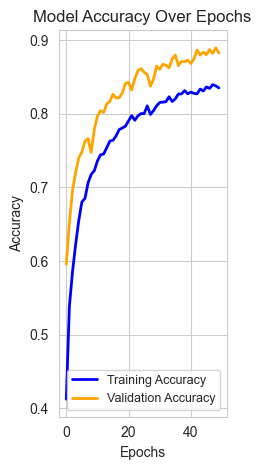

In [37]:
plt.subplot(1, 3, 1)
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.xlabel('Epochs', fontsize=10)  # Slightly smaller font size
plt.ylabel('Accuracy', fontsize=10)  # Slightly smaller font size
plt.legend(fontsize=9)  # Smaller legend font size
plt.title('Model Accuracy Over Epochs', fontsize=12)  # Smaller title font size
plt.tight_layout()  # Ensure no overlapping elements

In [32]:
# Plot Confusion Matrix (Example for one prediction)
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


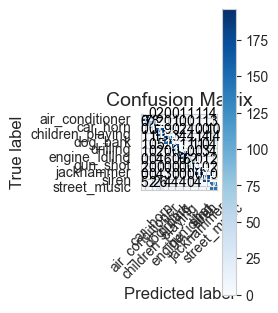

In [33]:
# Example confusion matrix for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm, classes=labelencoder.classes_, title='Confusion Matrix')

plt.tight_layout()
plt.show()